# Tvåskiktsmodellen (two-layer model)
Det här är en Jupyter Notebook som innehåller tvåskiktsmodellen. En Notebook innehåller textceller, som denna, och kodceller med Python-kod som går att köra cell för cell. Genom att följa instruktionerna kommer du att kunna köra tvåskiktsmodellen och skapa en figur med dina resultat!

Nedanför finns ett antal celler med Python-kod som gör olika saker. Det finns också text som förklarar vad koden i varje cell gör, både i form av textceller och i kommentarer, som börjar med #, i kodcellerna. Det som står efter ett # i en kodcell kommer Python att strunta i.

När man skriver kod använder man nästan alltid engelska, så det kommer vi att göra här också.

För att köra koden i en cell, klicka på symbolen ▶ till vänster i kodellen, eller klicka på cellen och tryck shift+enter.

In [ ]:
# We start by importing some modules with functions that we will need later
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

Här definierar vi en Python-funktion som heter `twolayermodel` som löser tvåskiktsmodellens två ekvationer och beräknar en temperaturanomali utifrån en given strålningsdrivning.

In [ ]:
def twolayermodel( # This is a Python function, it takes a list of arguments and returns a result
    input_forcing,
    ECS=3.0,            # Equilibrium climate sensitivity
    gamma=0.8,          # Heat uptake coefficient
    T_ml0=0.0,          # Mixed-layer temperature
    T_deep0=0.0,        # Deep layer temperature
    efficacy=1.0,       # Heat uptake efficacy
    color="blue",       # Color to plot this experiment in
    label=None          # Label for this experiment
):

    # Define time parameters in seconds:
    hour = 3600
    day = 24 * hour
    month = 30 * day
    year = 12 * month
    # Since the SI unit for time is seconds we need to convert all other units to seconds

    # Here we define some variables that will be needed by the model
    # There is no need for you to understand what is done here :)
    nyears = input_forcing.size
    delta_time = month
    nstep = round(nyears * year / delta_time)
    time = delta_time * xr.DataArray(np.arange(0, nstep, dtype=float), dims="time") + input_forcing.year.min() * year
    timeyears = time / year
    timeyears = xr.DataArray(timeyears, dims="time")
    forcing = input_forcing.interp(year=timeyears)

    # Parameters:
    f2x = 3.7                       # Forcing from a doubling of CO2
    density = 1000.0                # Density of water
    c_w = 4181.0                    # Specific heat capacty of water
    C_ml = 50 * density * c_w       # Heat capacity of the upper layer (mixed layer)
    C_deep = 1200 * density * c_w   # Heat capacity of the lower layer (deep layer)
    lambda_0 = -f2x / ECS           # Feedback parameter

    # Initialize state variables:
    T_ml = np.zeros(nstep)          # Temperature in the mixed layer
    T_deep = np.zeros(nstep)        # Temperature in the deep layer
    T_ml[0] = T_ml0                 # Initial temperature in the mixed layer
    T_deep[0] = T_deep0             # Initial temperature in the deep layer
    imbalance = np.zeros(nstep)     # Radiative imbalance

    # Integrate:
    # Here the two equations of the two-layer model are solved for each step in time
    # and the temperature is calculated
    imbalance[0] = np.nan
    for t in range(0, nstep - 1):
        T_ml[t + 1] = (
            T_ml[t]
            + (
                forcing[t]
                + lambda_0 * T_ml[t]
                - efficacy * gamma * (T_ml[t] - T_deep[t])
            )
            * delta_time
            / C_ml
        )
        T_deep[t + 1] = T_deep[t] + gamma * (T_ml[t] - T_deep[t]) * delta_time / C_deep
        imbalance[t + 1] = (
            C_ml * (T_ml[t + 1] - T_ml[t]) + C_deep * (T_deep[t + 1] - T_deep[t])
        ) / delta_time

    # Output result and settings for this run:
    result = xr.Dataset(coords={"time": timeyears})

    result["forcing"] = forcing
    result["T_ml"] = (["time"], T_ml)
    result["T_deep"] = (["time"], T_deep)
    result["imbalance"] = (["time"], imbalance)

    result["ECS"] = ECS
    result["C_ml"] = C_ml
    result["C_deep"] = C_deep
    result["gamma"] = gamma
    result["lambda_0"] = lambda_0
    result["efficacy"] = efficacy

    result.attrs["color"] = color
    result.attrs["label"] = label

    return result

Nu har vi definierat funktionen som löser ekvationerna i tvåskiktsmodellen. För att kunna köra modellen måste vi ge den värden för strålningsdrivningen vi vill använda i vårt experiment. Nu behöver vi läsa in data för hur strålningsdrivningen har ändrats från 1850 till 2011. När vi använder Google Colab måste vi tillåta Python att ansluta till Google Drive för att kunna läsa in data från filer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Här nedan läser vi in strålningsdrivningsdata från en fil. Enheten för strålningsdrivningen är $W/m^2$

In [ ]:
# Read the file with forcing data
data = np.loadtxt("/content/drive/MyDrive/Two-layer_model_data/WG1_AR5_Annex_II_sheet_1-2_forcings.txt", skiprows=1, unpack=True)

# Create a dataset with the forcing data to make it easier to work with
ds = xr.Dataset(
    {
        "F_co2": ("year", data[1]),         # Carbon dioxide
        "F_ghgother": ("year", data[2]),    # Other greenhouse gases
        "F_o3trop": ("year", data[3]),      # Tropospheric ozone
        "F_o3strat": ("year", data[4]),     # Stratospheric ozone
        "F_aero": ("year", data[5]),        # Anthropogenic aerosols
        "F_luc": ("year", data[6]),         # Land use change
        "F_h2ostrat": ("year", data[7]),    # Stratospheric water
        "F_bcsnow": ("year", data[8]),      # Black carbon on snow
        "F_contrails": ("year", data[9]),   # Contrails
        "F_solar": ("year", data[10]),      # Solar forcing
        "F_volc": ("year", data[11]),       # Volcanic aerosols
    },
    coords={"year": data[0]},
).sel(year=slice(1850, 2011))

Nästa steg är att summera alla olika strålningsdrivningskällor för att få en total strålningsdrivning (forcing på engelska).

In [ ]:
# Calculating the total forcing as the sum of all individual forcing agents
F_total_realistic = (
    ds.F_co2
    + ds.F_ghgother
    + ds.F_o3trop
    + ds.F_o3strat
    + ds.F_aero
    + ds.F_luc
    + ds.F_h2ostrat
    + ds.F_bcsnow
    + ds.F_contrails
    + ds.F_solar
    + ds.F_volc
)
# Subtract the forcing at the year 1850 to make sure we start at 0
F_total_realistic = F_total_realistic - F_total_realistic.sel(year=1850)



# Calculating the total forcing as the sum of all individual forcing agents
ds["F_aero_2"] = ds["F_aero"].where(ds.year < 2000, 0)
ds["F_aero_3"] = ds["F_aero"].where(ds.year >= 2000, 0)
F_total_more_aerosol = (
    ds.F_co2
    + ds.F_ghgother
    + ds.F_o3trop
    + ds.F_o3strat
    + ds.F_aero_2
    + 3.5 * ds.F_aero_3
    + ds.F_luc
    + ds.F_h2ostrat
    + ds.F_bcsnow
    + ds.F_contrails
    + ds.F_solar
    + ds.F_volc
)
# Subtract the forcing at the year 1850 to make sure we start at 0
F_total_more_aerosol = F_total_more_aerosol - F_total_more_aerosol.sel(year=1850)

# Calculating the total forcing as the sum of all individual forcing agents
ds["F_aero_2"] = ds["F_aero"].where(ds.year <= 2000, 0)
ds["F_co2_2"] = ds["F_co2"].where(ds.year <= 2000, 1.5104)

dif = ds.F_co2_2 - ds.F_co2_2.sel(year = 1850)


F_total_stop_2000 = (
    ds.F_co2_2
    + ds.F_ghgother
    + ds.F_o3trop
    + ds.F_o3strat
    + ds.F_aero_2
    + ds.F_luc
    + ds.F_h2ostrat
    + ds.F_bcsnow
    + ds.F_contrails
    + ds.F_solar
    + ds.F_volc
)
# Subtract the forcing at the year 1850 to make sure we start at 0
F_total_stop_2000 = F_total_stop_2000 - F_total_stop_2000.sel(year=1850)

# Calculating the total forcing as the sum of all individual forcing agents
F_aerosol = (
    ds.F_aero
)
# Subtract the forcing at the year 1850 to make sure we start at 0
F_aerosol = F_aerosol - F_aerosol.sel(year=1850)

# Calculating the total forcing as the sum of all individual forcing agents
F_only_co2 = (
    ds.F_co2
)
# Subtract the forcing at the year 1850 to make sure we start at 0
F_only_co2 = F_only_co2 - F_only_co2.sel(year=1850)


Nu har vi definierat den totala strålningsdrivning som vi vill använda. I cellen nedan kör vi modellen genom att kalla funktionen `twolayermodel` med vår strålningsdrivning `F_total` som argument. Vårt första experiment (som får heta `exp`) är en realistisk simulering utan några ändringar av strålningsdrivningen.

In [ ]:
# Run the two-layer model
exp_realistic = twolayermodel(F_total_realistic, ECS=3.0, label="Realistisk simulering", color="blue")

exp_only_aerosol = twolayermodel(F_aerosol, ECS=3.0, label="Effect of aerosol", color="green")

exp_more_aerosol = twolayermodel(F_total_more_aerosol, ECS=3.0, label="3.5x aerosoler e. 2000", color="red")

exp_stop_2000 = twolayermodel(F_total_stop_2000, ECS=3.0, label="Inga co2 / aerosolutsläpp e. 2000", color="yellow")

exp_only_co2 = twolayermodel(F_only_co2, ECS=3.0, label="Effect of co2", color="purple")


För att kunna jämföra med mätdata läser vi in ett dataset som heter HadCRUT. Information om det datasetet kan ni hitta [här](https://www.metoffice.gov.uk/hadobs/hadcrut5/).

In [ ]:
# Open the file with the observational data
HadCRU_data = xr.open_dataset("/content/drive/MyDrive/Two-layer_model_data/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.nc").squeeze()
HadCRU_data["time"] = HadCRU_data["time"].dt.year
# This line above is just to remove some extra information that we don't need,
# to make the data easier to work with

# Compute the temperature anomaly compared to the average from 1850 to 1880
observed_temperature = HadCRU_data["tas_mean"] - HadCRU_data["tas_mean"].sel(time=slice(1850, 1880)).mean("time")

Vi kan också jämföra med modelldata från MPI-ESM1.2. En beskrivning av denna ESM finns i en artikel av [Mauritsen et al. 2019](https://doi.org/10.1029/2018MS001400).

In [ ]:
# Open the file with ESM data
MPIESM_data = xr.open_dataset("/content/drive/MyDrive/Two-layer_model_data/MPI-ESM1-2-CR_historical_bg1_r1_1850-2013_fldmean_yearmean.nc").squeeze()
# Here we manipulate the data a bit to make it easier to access
MPIESM_data["time"] = pd.to_datetime(MPIESM_data["time"].values.astype(int).astype(str), format='%Y%m%d')
MPIESM_data["time"] = MPIESM_data["time"].dt.year

# Compute the temperature anomaly compared to the average from 1850 to 1880
ESM_temperature = MPIESM_data["tsurf"] - MPIESM_data["tsurf"].sel(time=slice(1850, 1880)).mean("time")


# Now we do the same thing but for the EMS forcing
MPIESM_forcing_data = xr.open_dataset("/content/drive/MyDrive/Two-layer_model_data/MPI-ESM1-2-CR_historical_bg1_piSST_r1_1851-2014_fldmean_yearmean.nc").squeeze()

MPIESM_forcing_data["time"] = pd.to_datetime(MPIESM_forcing_data["time"].values.astype(int).astype(str), format='%Y%m%d')
MPIESM_forcing_data["time"] = MPIESM_forcing_data["time"].dt.year
forcing = MPIESM_forcing_data["srad0"] + MPIESM_forcing_data["trad0"]

ESM_forcing = forcing - forcing.sel(time=slice(1850, 1880)).mean("time")

Nu har vi kört våra experiment och läst in mätdatan och ESM-datan som vi vill jämföra med. Nu återstår bara att skapa en figur som visar resultatet!

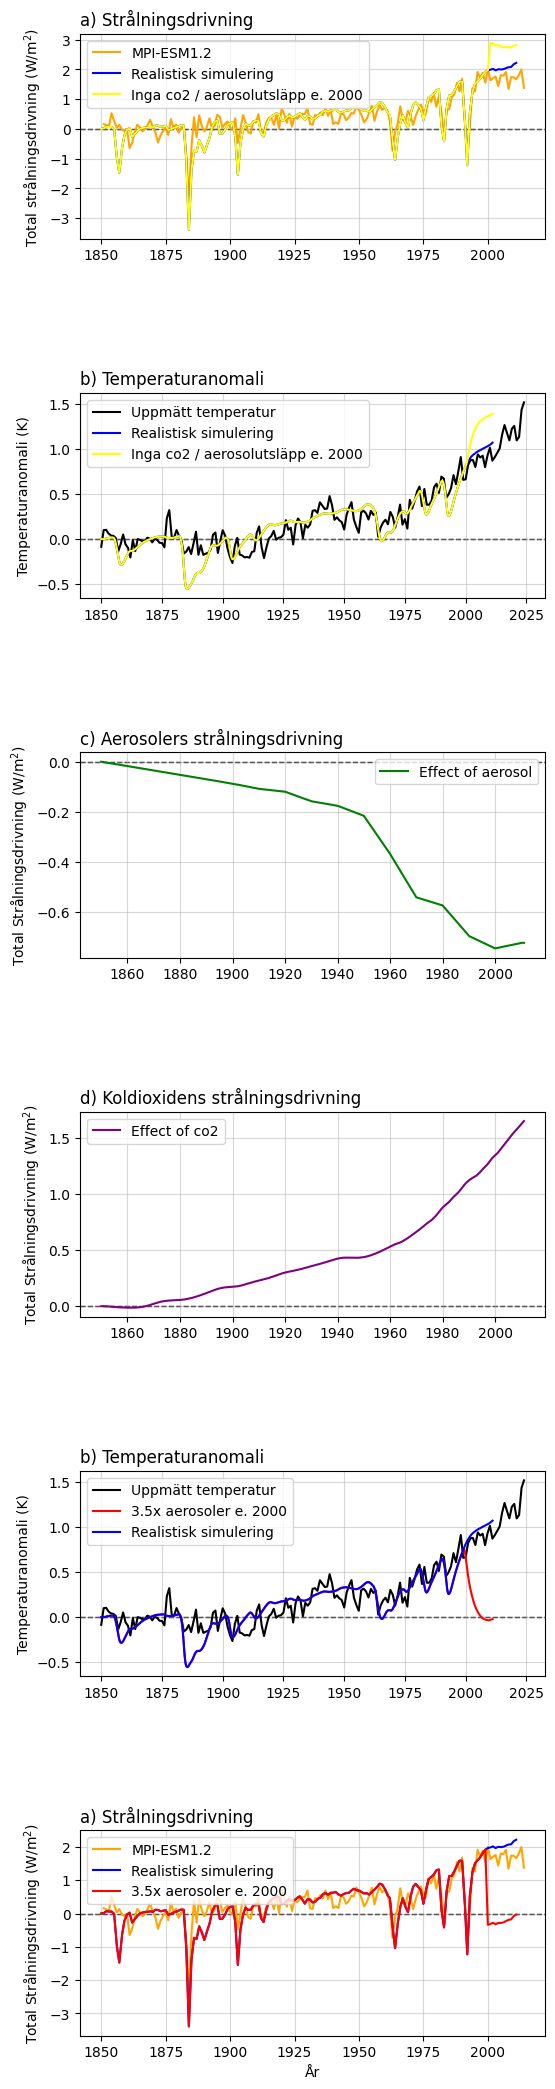

In [ ]:
# Create a figure with two panels, one for temperature and one for forcing
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(6, 26), sharex=False)

# Plot the radiative forcing and temperature of all experiments:

ax1.plot(ESM_forcing["time"], ESM_forcing, color="orange", label="MPI-ESM1.2")
ax1.plot(exp_realistic["time"], exp_realistic["forcing"], color=exp_realistic.attrs["color"], label=exp_realistic.attrs["label"])
ax1.plot(exp_stop_2000["time"], exp_stop_2000["forcing"], color=exp_stop_2000.attrs["color"], label=exp_stop_2000.attrs["label"])


ax2.plot(observed_temperature["time"], observed_temperature, color="black", label="Uppmätt temperatur")
ax2.plot(exp_realistic["time"], exp_realistic["T_ml"], color=exp_realistic.attrs["color"], label=exp_realistic.attrs["label"])
ax2.plot(exp_stop_2000["time"], exp_stop_2000["T_ml"], color=exp_stop_2000.attrs["color"], label=exp_stop_2000.attrs["label"])


ax3.plot(exp_only_aerosol["time"], exp_only_aerosol["forcing"], color=exp_only_aerosol.attrs["color"], label=exp_only_aerosol.attrs["label"])


ax4.plot(exp_only_co2["time"], exp_only_co2["forcing"], color=exp_only_co2.attrs["color"], label=exp_only_co2.attrs["label"])


ax5.plot(observed_temperature["time"], observed_temperature, color="black", label="Uppmätt temperatur",)
ax5.plot(exp_more_aerosol["time"], exp_more_aerosol["T_ml"], color=exp_more_aerosol.attrs["color"], label=exp_more_aerosol.attrs["label"])
ax5.plot(exp_realistic["time"], exp_realistic["T_ml"], color=exp_realistic.attrs["color"], label=exp_realistic.attrs["label"])


ax6.plot(ESM_forcing["time"], ESM_forcing, color="orange", label="MPI-ESM1.2",)
ax6.plot(exp_realistic["time"], exp_realistic["forcing"], color=exp_realistic.attrs["color"], label=exp_realistic.attrs["label"])
ax6.plot(exp_more_aerosol["time"], exp_more_aerosol["forcing"], color=exp_more_aerosol.attrs["color"], label=exp_more_aerosol.attrs["label"])

# Here below we add some additional information to the figure

# Title for each panel
ax1.set_title("a) Strålningsdrivning", loc="left")
ax2.set_title("b) Temperaturanomali", loc="left")
ax3.set_title("c) Aerosolers strålningsdrivning", loc="left")
ax4.set_title("d) Koldioxidens strålningsdrivning", loc="left")
ax5.set_title("b) Temperaturanomali", loc="left")
ax6.set_title("a) Strålningsdrivning", loc="left")

# Legends showing the colors of each line in the plot
ax1.legend(loc = 2)
ax2.legend(loc = 2)
ax3.legend(loc = 1)
ax4.legend(loc = 2)
ax5.legend(loc = 2)
ax6.legend(loc = 2)

# A grid to make the figure easier to read
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
ax4.grid(alpha=0.5)
ax5.grid(alpha=0.5)
ax6.grid(alpha=0.5)

# Information on the y-axis about what variable is plotted in each panel
ax2.set_ylabel("Temperaturanomali (K)")
ax1.set_ylabel(r"Total strålningsdrivning (W/m$^2$)")
ax3.set_ylabel(r"Total Strålningsdrivning (W/m$^2$)")
ax4.set_ylabel(r"Total Strålningsdrivning (W/m$^2$)")
ax5.set_ylabel("Temperaturanomali (K)")
ax6.set_ylabel(r"Total Strålningsdrivning (W/m$^2$)")

# Information on the x-axis
ax6.set_xlabel("År")

# Add a horizontal line to mark zero
ax1.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)
ax2.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)
ax3.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)
ax4.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)
ax5.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)
ax6.axhline(0, color="black", linewidth=1.0, linestyle="dashed", zorder=-10)

# Adjust the vertical spacing between the two panels
fig.subplots_adjust(hspace=0.75)

# Save the figure with the name "Resultat.png"
fig.savefig("Resultat.png", bbox_inches="tight")

Nu har vi skapat en figur som visar både strålningsdrivningen och temperaturanomalin från experimenten. Om du vill kan du byta namn på filen som figuren finns i. För att göra det behöver du bara byta ut `fig.savefig("Resultat.png", bbox_inches="tight")` mot `fig.savefig("Nytt_namn.png", bbox_inches="tight")`. På så sätt kan du göra flera olika varianter av figuren, till exempel med och utan den observerade temperaturen, och spara i olika filer.

Du kan också välja att spara figuren i ett annat filformat än `.png`, till exempel `.pdf`, genom att byta ut `.png` i samma rad som ovan. Den sparade figuren kan du hitta under "Files" i menyn längs skärmens vänsterkant, därifrån kan du ladda ned figuren.